In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# import and cleaning of data
trend = pd.read_csv('Denguefever_Timeline.csv')
trend = trend.iloc[1:-1]
trend.rename(columns = {'Category: All categories':'records'}, inplace=True)
trend['records'] = trend['records'].astype(int)
trend.head()

,records
2004-01,0
2004-02,22
2004-03,20
2004-04,14
2004-05,0


In [3]:
# setting datetime index
trend.reset_index(inplace=True)
trend['index'] = pd.to_datetime(trend['index'])
trend.set_index('index', inplace=True)
trend.head()

,records
index,
2004-01-01,0
2004-02-01,22
2004-03-01,20
2004-04-01,14
2004-05-01,0


In [4]:
# define function to plot ARIMA data
def plot_data(train, test, pred, type):
    plt.figure(figsize=(10,6))
    plt.plot(train, color = 'blue')
    plt.plot(test, color = 'orange')
    plt.plot(pred, color = 'green')
    plt.title(label = f'Dengue Google Search {type} model', fontsize=18)
    plt.show()

In [5]:
trend.shape[0]

243

In [6]:
trend.shape[0] * 4/5

194.4

In [7]:
# train test split 80/20

train = trend.iloc[0:194]
test = trend.iloc[194:]


In [8]:
ar1 = sm.tsa.arima.ARIMA(endog = train['records'],
            order = (1, 0, 0))

model1 = ar1.fit()

pred1 = model1.predict(start=194, end=242)

# Evaluate predictions with MSE
mean_squared_error(test['records'], pred1)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


122.26884697268056

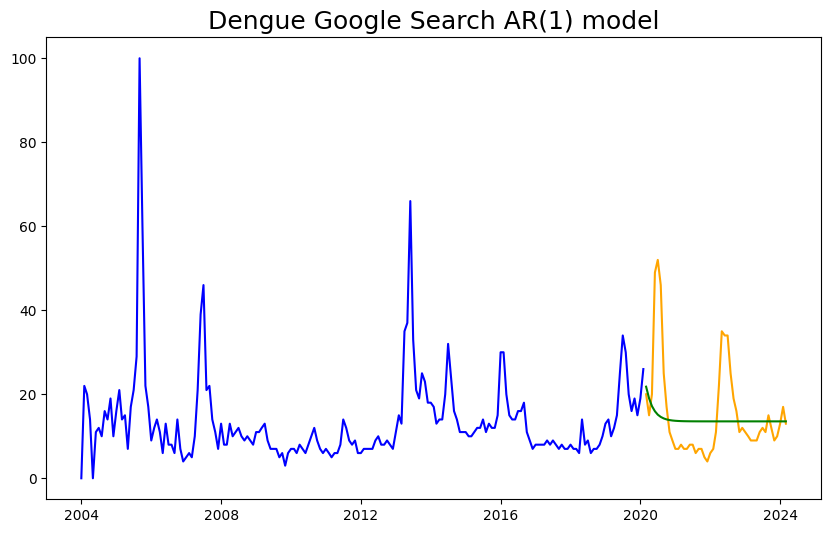

In [9]:
plot_data(train['records'], test['records'], pred1, 'AR(1)')

The first model does not look to be a very good model, let us explore further with the autocorrelation and evidence from the EDA previously

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


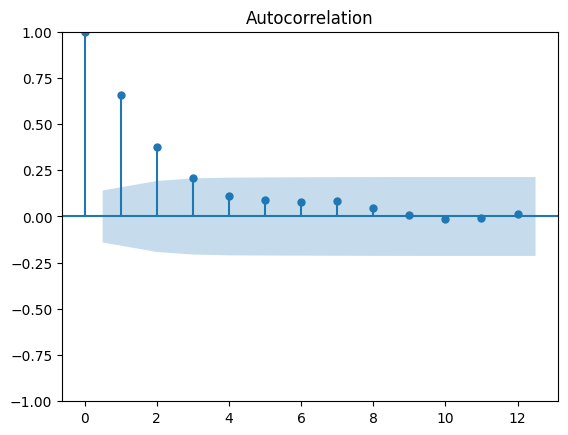

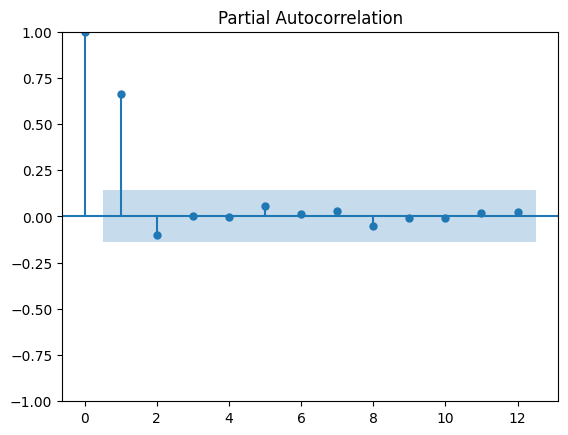

In [10]:
plot_acf(train['records'], lags = 12)
plot_pacf(train['records'], lags = 12);

From the above, with ACF gradually wear off and PACF suddenly cut off, it looks to be pointing towards AR model  
From PACF, with value 1 looks to offer significance value  
At the same time, previous EDA indicates that the first order difference could remove stationarity  
Therefore, let us try ARIMA(1,1,1) and ARIMA(2,1,1)

In [11]:
ar2 = sm.tsa.arima.ARIMA(endog = train['records'],
            order = (1, 1, 1))

model2 = ar2.fit()

pred2 = model2.predict(start=194, end=242)

# Evaluate predictions with MSE
mean_squared_error(test['records'], pred2)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


121.84896703413786

Slightly better, let's plot the chart

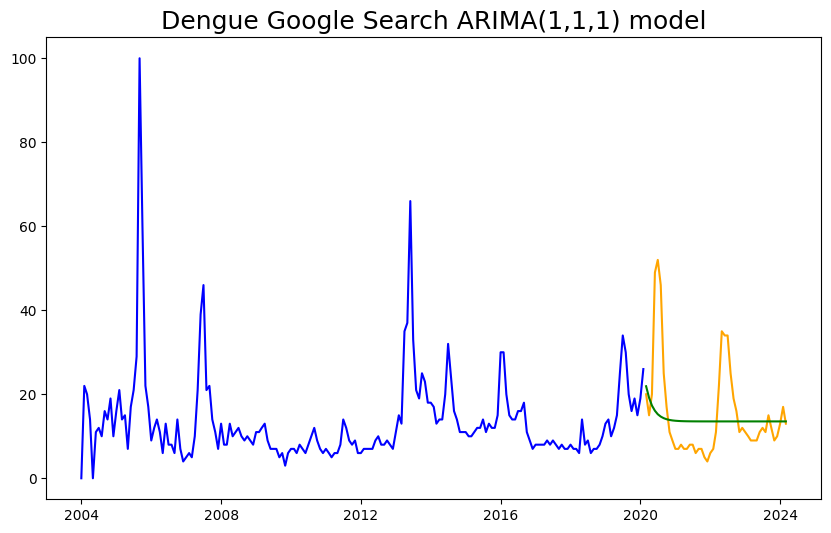

In [12]:
plot_data(train['records'], test['records'], pred2, 'ARIMA(1,1,1)')

In [13]:
ar3 = sm.tsa.arima.ARIMA(endog = train['records'],
            order = (2, 1, 1))

model3 = ar3.fit()

pred3 = model3.predict(start=194, end=242)

# Evaluate predictions with MSE
mean_squared_error(test['records'], pred3)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


125.65246045380077

It looks like ARIMA(1,1,1) has the best model so far, however, the charts does seem to have some degree of seasonality.

Furthermore, the data is monthly data, so with a lag of 12 merely covers past 1 year worth of data.  
In order to explore any potentially seasonality, let us extend the ACF and PACF analysis to wider range.

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


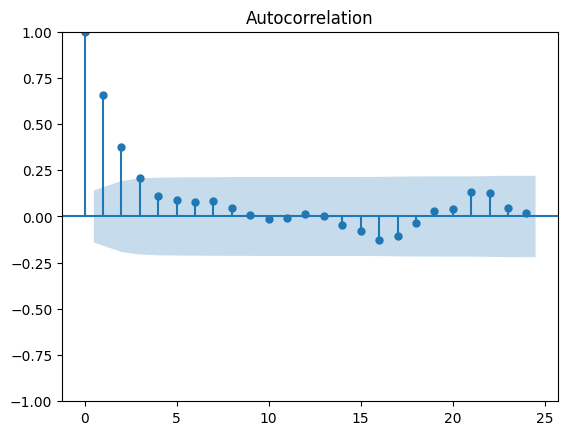

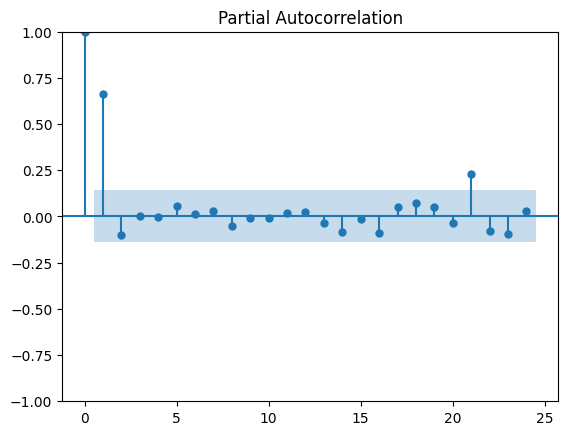

In [14]:
plot_acf(train['records'], lags = 24)
plot_pacf(train['records'], lags = 24);

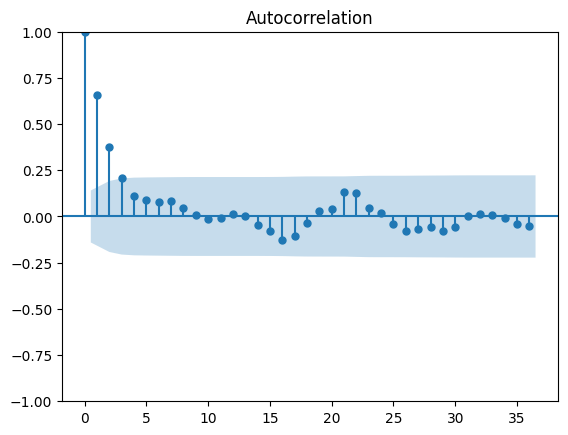

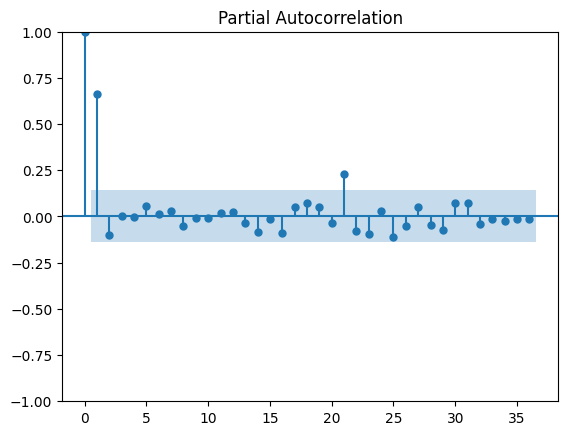

In [15]:
plot_acf(train['records'], lags = 36)
plot_pacf(train['records'], lags = 36);

With PACF showing a spike in 21st lag, it might be a hint of a possible usage of SARIMA

In [16]:
# fitting a SARIMA model with the best ARIMA identified earlier (1,1,1)

sarima = SARIMAX(endog = train['records'],
                 order = (1, 1, 1),              # (p, d, q)
                 seasonal_order = (1, 1, 1, 21)) # (P, D, Q, S)

model4 = sarima.fit()

pred4 = model4.predict(start=194, end=242)

# Evaluate predictions with MSE
mean_squared_error(test['records'], pred4)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


159.33351095986058

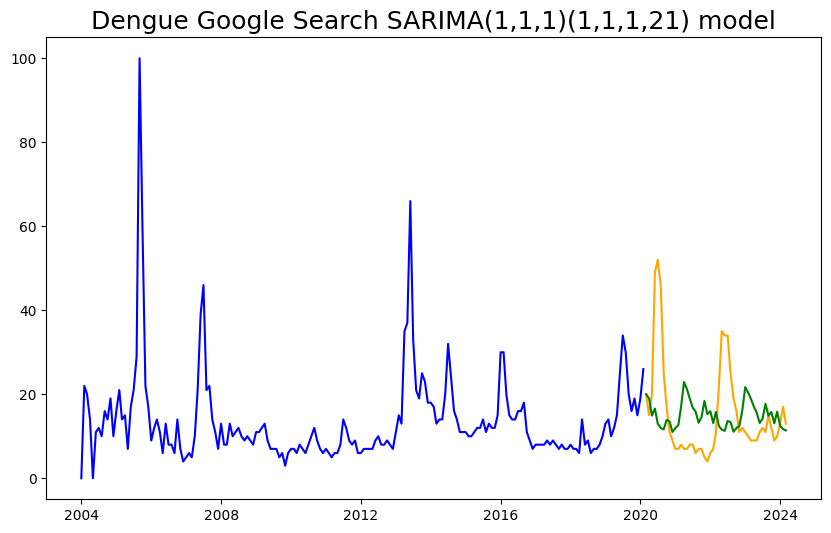

In [17]:
plot_data(train['records'], test['records'], pred4, 'SARIMA(1,1,1)(1,1,1,21)')

In [18]:
sarima2 = SARIMAX(endog = train['records'],
                 order = (1, 1, 1),              # (p, d, q)
                 seasonal_order = (2, 1, 1, 21)) # (P, D, Q, S)

model5 = sarima2.fit()

pred5 = model5.predict(start=194, end=242)

# Evaluate predictions with MSE
mean_squared_error(test['records'], pred5)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


157.41125063259827

In [37]:
train['records'].std()

10.863730724970866

In [35]:
157.41125063259827 ** 0.5

12.546364040334485

In [19]:
sarima3 = SARIMAX(endog = train['records'],
                 order = (2, 1, 1),              # (p, d, q)
                 seasonal_order = (2, 1, 1, 21)) # (P, D, Q, S)

model6 = sarima3.fit()

pred6 = model6.predict(start=194, end=242)

# Evaluate predictions with MSE
mean_squared_error(test['records'], pred6)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\bas

158.122145705192

Interestingly, SARIMA (1,1,1)(2,1,1,21) offers the best performance amongst SARIMA. However, SARIMA in general does not offer better performance compared to ARIMA.  
This is despite a clear seasonality shown in the data.  
It is possible that this "seasonality" might not have a clear repeating pattern, meaning it might be due to factors other than time

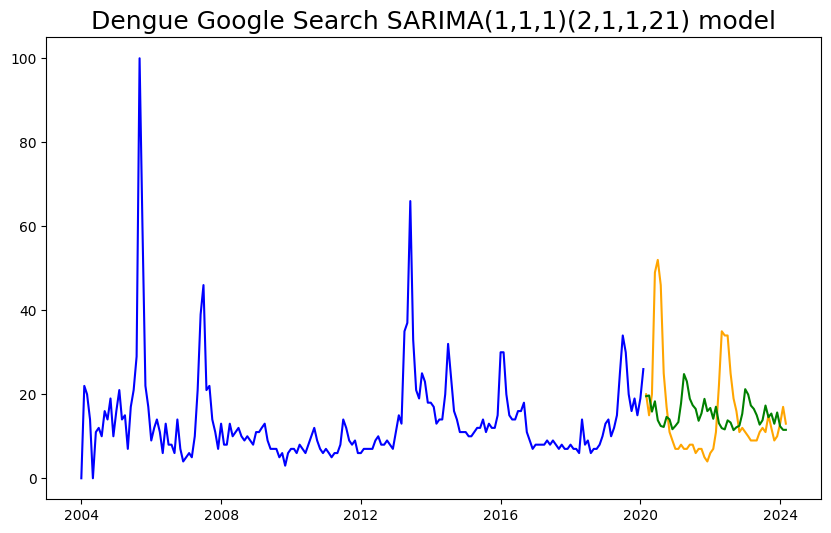

In [20]:
plot_data(train['records'], test['records'], pred5, 'SARIMA(1,1,1)(2,1,1,21)')

### Cross inference dengue cases

Attempt usage of ARIMA and SARIMA are mainly focused on predicting the Google Search.  
However, the underlying purpose of making such model is to predict dengue cases.  
Therefore, let us import the dengue cases and compare it with ARIMA results from Google Search

In [21]:
# read the data
dengue = pd.read_csv('WeeklyNumberofDengueandDengueHaemorrhagicFeverCases.csv')

# change to datetime format for easy manipulation
dengue['year-week'] = pd.to_datetime(dengue['year'].astype(str) + ' ' + dengue['eweek'].astype(str) + ' 3', format='%G %V %u')

# filter out information of interest and reset index
dengue_f = dengue[['year-week', 'number']]
dengue_f.set_index('year-week', inplace=True)

# resample in monthly data to match Google search data
dengue_monthly = dengue_f.resample('M').sum()

# check the data
dengue_monthly.head()

,number
year-week,
2014-01-31,1887.0
2014-02-28,1024.0
2014-03-31,870.0
2014-04-30,1253.0
2014-05-31,1436.0


In [22]:
# Filter out data from 2004 to 2019 and resampling into monthly data
# This is to match the above dengue data that we have

trend_0419 = trend.loc['2004-01-01':'2019-01-01']
trend_0419 = trend_0419.resample('M').sum()
trend_0419.head()

,records
index,
2004-01-31,0
2004-02-29,22
2004-03-31,20
2004-04-30,14
2004-05-31,0


In [23]:
trend_0419.shape[0]*4/5

144.8

In [24]:
trend_0419.shape[0]

181

In [25]:
# train test split
train2 = trend_0419.iloc[0:145]
test2 = trend_0419.iloc[145:]

# build a new ARIMA following the previous ARIMA
ar0419_1 = sm.tsa.arima.ARIMA(endog = train2['records'],
            order = (1, 1, 1))

# fit the model
model0419_1 = ar0419_1.fit()

# predict
pred0419_1 = model0419_1.predict(start=145, end=180)

# Evaluate predictions with MSE
mean_squared_error(test2['records'], pred0419_1)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


28.571828694661942

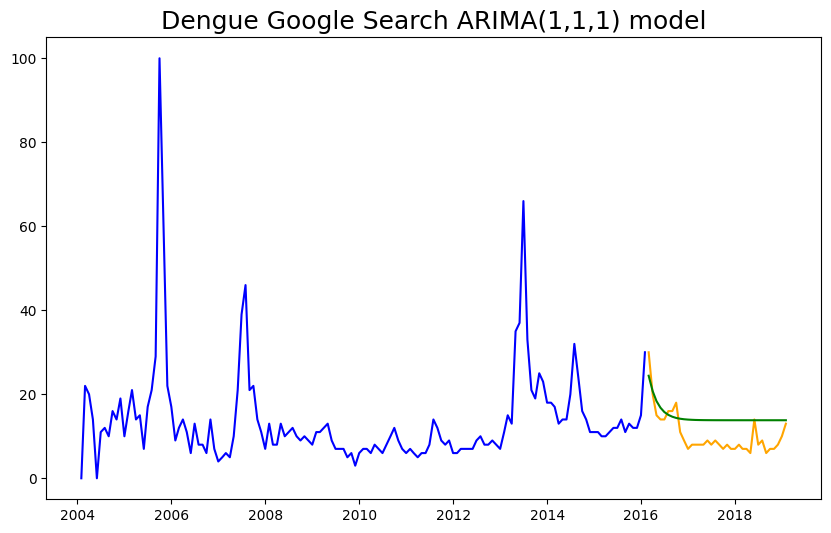

In [26]:
plot_data(train2['records'], test2['records'], pred0419_1, 'ARIMA(1,1,1)')

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


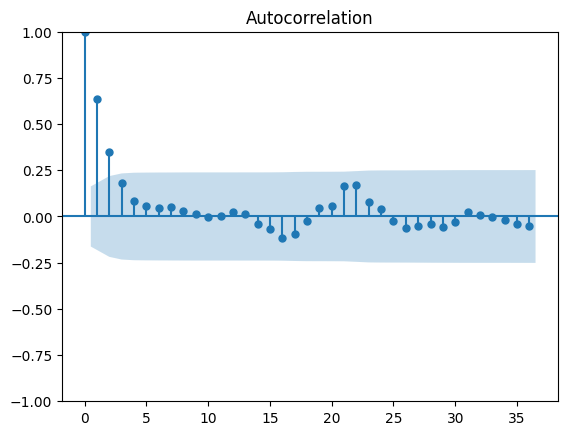

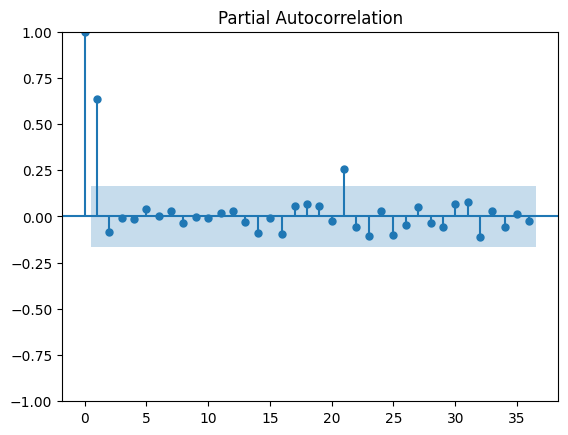

In [27]:
plot_acf(train2['records'], lags = 36)
plot_pacf(train2['records'], lags = 36);

The new Google trend data set looks to have similar ACF and PACF, so let's replicate what we did

In [28]:
ar0419_2 = SARIMAX(endog = train2['records'],
                 order = (1, 1, 1),              # (p, d, q)
                 seasonal_order = (1, 1, 1, 21)) # (P, D, Q, S)

model0419_2 = ar0419_2.fit()

pred0419_2 = model0419_2.predict(start=145, end=180)

# Evaluate predictions with MSE
mean_squared_error(test2['records'], pred0419_2)

107.95446881840303

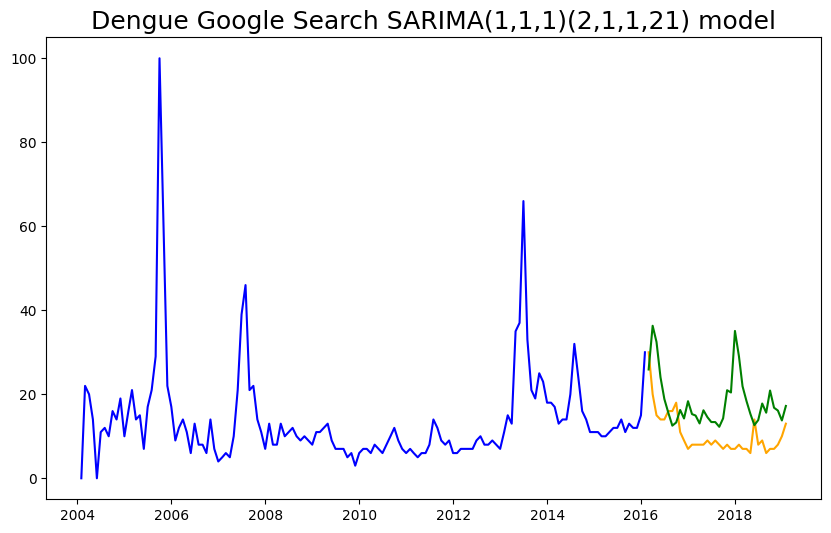

In [29]:
plot_data(train2['records'], test2['records'], pred0419_2, 'SARIMA(1,1,1)(2,1,1,21)')

Now let us compare the results from the SARIMA with the dengue cases

In [30]:
pred0419_2.index

DatetimeIndex(['2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
               '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
               '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
               '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
               '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31'],
              dtype='datetime64[ns]', freq='M')

In [31]:
mean_squared_error(dengue_monthly.loc['2016-02-29':'2019-01-31'], pred0419_2)

403735.5208490193

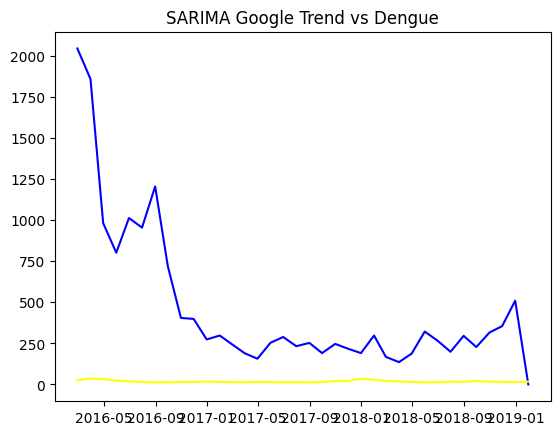

In [32]:
plt.plot(dengue_monthly.loc['2016-02-29':'2019-01-31'], color='blue')
plt.plot(pred0419_2, color='yellow')
plt.title('SARIMA Google Trend vs Dengue')
plt.show()

Does not look offer much insights, let's do on separate axis

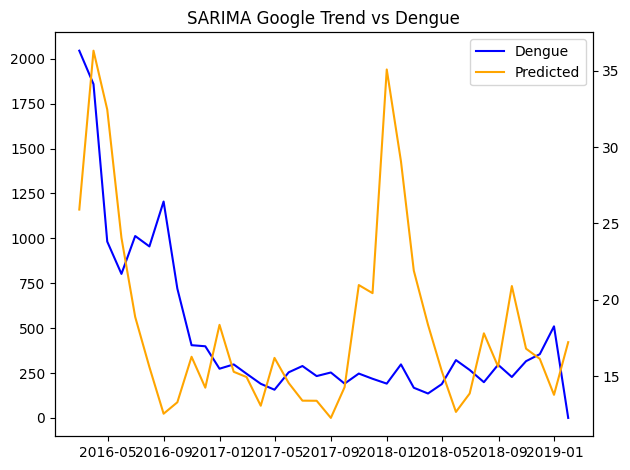

In [33]:
fig, ax1 = plt.subplots()

ax1.plot(dengue_monthly.loc['2016-02-29':'2019-01-31'], color='blue', label='Dengue')

ax2 = ax1.twinx()
ax2.plot(pred0419_2, color='orange',label='Predicted')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('SARIMA Google Trend vs Dengue')
plt.tight_layout()
plt.show()

In this chart, the SARIMA model predicted that there might be a spike in Google Search on "Dengue" in Feb 2018, but that did not lead to a spike in Dengue cases reported.  
However, The model did then predicted a spike in early 2019, which then pointed to some extent of higher dengue cases reported